In [2]:
import ipywidgets as widgets

In [3]:
widgets.IntRangeSlider(
    value=[5, 7],
    min=0,
    max=2**15,
    step=2**6,
    description='Test:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d',
)

IntRangeSlider(value=(5, 7), continuous_update=False, description='Test:', max=32768, step=64)

In [4]:
from data import toy_data
import numpy as np
import matplotlib.pyplot as plt

%matplotlib notebook

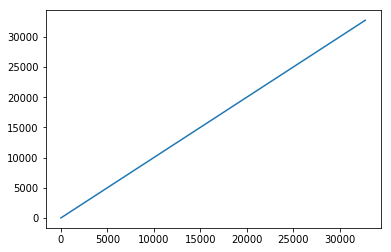

In [5]:
plt.plot([x for x in range(2**15)])
plt.show()

In [ ]:
plt.rc('font', family='serif')
plt.rc('xtick', labelsize=8)
plt.rc('ytick', labelsize=8)
plt.rc('axes', labelsize=8)
plt.rc('figure', autolayout=True, dpi=300)
plt.rc('lines', linewidth=1)
plt.rc('legend', fontsize=8)

In [ ]:
plt.figure(figsize=(6, 3))
T = 3000
wavelengths = np.linspace(0, 3e-6, num=2**12+1)[1:]
for T in [4000, 5000, 6000]:
    plt.plot(wavelengths / 1e-6, toy_data.planck(wavelengths, T), label='T = {} K'.format(T))
    
plt.xlabel('Wavelength [$\mu$m]')

plt.ylabel('Spectral radiance [W sr$^{-1}$ m$^{-3}$]')
plt.legend()


In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import tables

In [3]:
h5file = tables.open_file('data/sample_short.h5', 'r')
#h5file = tables.open_file('sample_real_stars.h5', 'r')
h5node = h5file.get_node('/spectra')

In [4]:
h5node

/spectra (Table(16000,), shuffle, blosc(9)) ''
  description := {
  "MH_ratio": Float64Col(shape=(), dflt=0.0, pos=0),
  "T_eff": Float64Col(shape=(), dflt=0.0, pos=1),
  "abundances": Float64Col(shape=(83,), dflt=0.0, pos=2),
  "alphaM_ratio": Float64Col(shape=(), dflt=0.0, pos=3),
  "log_g": Float64Col(shape=(), dflt=0.0, pos=4),
  "row_id": Int32Col(shape=(), dflt=0, pos=5),
  "spectrum": Float32Col(shape=(32768,), dflt=0.0, pos=6)}
  byteorder := 'little'
  chunkshape := (3,)

In [ ]:
spectra = np.array([x['spectrum'] for x in h5node.iterrows(step=8000//20)])

In [ ]:
current_lambda = 500
lambdas = [500]
for i in range(1, spectra.shape[1]):
    if current_lambda >= 500 and current_lambda <= 3000:
        current_lambda += .1
    elif current_lambda > 3000 and current_lambda <= 25000:
        delta = current_lambda / 650000
        current_lambda += delta
    elif current_lambda > 25000 and current_lambda <= 55000:
        delta = current_lambda / 250000
        current_lambda += delta
    lambdas.append(current_lambda)

In [ ]:
plt.figure(figsize=(6, 3))
plt.plot(lambdas[711000:715000], spectra[3][711000:715000])
plt.plot(lambdas[711000:715000], spectra[18][711000:715000])
plt.xlabel('Wavelength [$\mu$m]')
plt.ylabel('Spectral radiance [W sr$^{-1}$ m$^{-3}$]')

In [ ]:
plt.figure(figsize=(10, 10))
for i in range(len(spectra)):
    plt.plot(spectra[i][712000:714000], label=i)
plt.legend()

In [ ]:
np.save('test', spectra)

In [ ]:
np.savez_compressed('test', spectra=spectra)

In [ ]:
for spectrum in spectra[:5]:
    plt.plot(spectrum)

In [ ]:
normalized_spectra = spectra / np.max(spectra, axis=1)[:, np.newaxis]

In [ ]:
for spectrum in normalized_spectra[:5]:
    plt.plot(spectrum)

In [ ]:
wavelengths = np.linspace(500e-10, 5.5e-6, len(normalized_spectra[22]))

In [ ]:
#plt.figure(dpi=300, figsize=(20, 15))
plt.figure(figsize=(20, 15))
plt.rcParams.update({'font.size': 24})
plt.plot(wavelengths*1e6, normalized_spectra[22])
#plt.plot(normalized_spectra[23])
plt.xlabel('wavelength ($\mu m$)')
plt.ylabel('normalized intensity')

In [ ]:
start, stop = 0, -1#700000, 700000+2**15
plt.figure(figsize=(40,10))
for spectrum in normalized_spectra[:50]:
    plt.plot(spectrum[start:stop])
plt.xlim(12000, 14000)

In [ ]:
normalized_spectra = np.array([spectrum / np.max(spectrum) for spectrum in spectra])
#TODO: use np

In [ ]:
normalized_spectra = spectra / np.max(spectra, axis=1)[:, np.newaxis]

In [ ]:
Y = np.matmul(normalized_spectra, normalized_spectra.T)

In [ ]:
plt.plot(Y[0])

In [ ]:
u, s, vh = np.linalg.svd(Y)
print(s)

In [ ]:
plt.plot(range(1, 11), s[:10] / s[0])
plt.xlabel("singular value index")
plt.xticks(range(1, 11))
plt.ylabel("squared singular value (normalized by largest)")

In [ ]:
plt.plot(range(1, 11), np.sqrt(s[:10]) / np.sqrt(s[0]))
plt.xlabel("singular value index")
plt.xticks(range(1, 11))
plt.ylabel("singular value (normalized by largest)")

In [ ]:
from datetime import datetime
import tables
import matplotlib.pyplot as plt

In [ ]:
file = np.load('output/output-190910-154018.npz')
ws = file['ws']
bs = file['bs']

In [ ]:
h5file = tables.open_file('data/sample_8k.h5', 'r')
h5node = h5file.get_node('/spectra')

spectra = h5node[:100]['spectrum']
normalized_spectra = spectra / np.max(spectra, axis=1)[:, np.newaxis]

h5file.close()

In [ ]:
def recreate_spectra(spectrum, ws, bs):
    NUM_FEATURES = 40
    s = np.copy(spectrum)
    i = 0
    while i < len(ws):
        #print(i, ws[i].shape, s.shape)
        if (np.size(ws[i], 0) != np.size(s, 0)): # check if we're at the sampling step and sample
            s = np.random.normal(s[:NUM_FEATURES], s[NUM_FEATURES:], (NUM_FEATURES,))
        else:
            s = np.clip(ws[i].T @ s + bs[i], 0, None)
            i = i + 1
    return s

In [ ]:
INDEX = 1
recreation = recreate_spectra(normalized_spectra[INDEX][700000:750000], ws, bs)
#left, right = [int(i * SPECTRA_FEATURES) for i in (0, 1)]
left, right = 700000, 750000
plt.figure(figsize=(40,10))
plt.plot(recreation)
plt.plot(normalized_spectra[INDEX][700000:750000])

In [ ]:
h5file = tables.open_file('data/sample_8k.h5', 'r')
h5node = h5file.get_node('/spectra')

In [ ]:
log_gs = h5node[:2000]["log_g"]
T_effs = h5node[:2000]["T_eff"]

In [ ]:
%time data = [(x['log_g'], x['T_eff']) for x in h5node.iterrows()]

In [ ]:
log_gs = np.array(data)[:, 0]
T_effs = np.array(data)[:, 1]

In [ ]:
plt.scatter(log_gs, T_effs, alpha=.05)

In [ ]:
plt.hist(log_gs)

In [ ]:
plt.hist(T_effs)

In [ ]:
h5file.close()